### Regression results

In [1]:
import numpy as np
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)
import tensorflow.contrib.slim as slim
import matplotlib.pyplot as plt
%matplotlib inline  
%config InlineBackend.figure_format = 'retina'
from cn_reg_class import cn_reg_class
from mlp_reg_class import mlp_reg_class
from sklearn.datasets import load_boston
from util import nzr,get_train_test_datasets,gpusession,print_n_txt
print ("Packages loaded")

Packages loaded


### Summarize results

In [2]:
# Configurations
dataset,dataset_name = load_boston(),'boston' # select dataset to use
test_size = 0.2
outlier_rates = [0,0.05,0.1,0.15,0.2,0.3,0.4,0.5]
rseeds = [0,1,2,3,4,5]
h_dims = [256,128]
actv = tf.nn.relu
l2_reg_coef = 1e-4

# Flags
RUN_CN = 1
RUN_L2 = 1
RUN_L1 = 1
RUN_RBST = 1
RUN_LRBST = 1
SAVE_TXT = True
SAVE_FINAL = False
SAVE_BEST = True
REMOVE_PREVS = True

# RMSEs to save
rmses_cn = np.zeros(shape=(len(outlier_rates),len(rseeds)))
rmses_l2 = np.zeros(shape=(len(outlier_rates),len(rseeds)))
rmses_l1 = np.zeros(shape=(len(outlier_rates),len(rseeds)))
rmses_robust = np.zeros(shape=(len(outlier_rates),len(rseeds)))
rmses_leaky_robust = np.zeros(shape=(len(outlier_rates),len(rseeds)))

# Save to txt
txt_name = 'res/robust_regression_results.txt'
f = open(txt_name,'w')

for s_idx,rseed in enumerate(rseeds): # for differnt random seeds
    for o_idx,outlier_rate in enumerate(outlier_rates): # for different outlier rates
        x_train,x_test,y_train,y_test = get_train_test_datasets(
            dataset,dataset_name,_test_size=test_size,_outlier_rate=outlier_rate,
            _seed=rseed,_SAVE_MAT=False,_VERBOSE=False) # get training data with outliers
        # 1. Run ChoiceNet
        if RUN_CN:
            tf.reset_default_graph(); sess = gpusession()
            tf.set_random_seed(rseed); np.random.seed(rseed) # fix seeds
            CN = cn_reg_class(_name='cn_%s_err%02d_seed%d'%(dataset_name,outlier_rate*100,rseed),_x_dim=np.shape(x_train)[1],_y_dim=1,
                              _h_dims=h_dims,_k_mix=10,_actv=actv,_bn=slim.batch_norm,
                              _rho_ref_train=0.95,_tau_inv=1e-2,_var_eps=1e-4,
                              _pi1_bias=0.0,_log_sigma_Z_val=-1,
                              _kl_reg_coef=1e-6,_l2_reg_coef=l2_reg_coef,
                              _SCHEDULE_MDN_REG=0,_GPU_ID=1,_VERBOSE=0)
            sess.run(tf.global_variables_initializer()) # initialize variables
            CN.restore_from_npz(sess,_loadname='net/net_%s_best.npz'%(CN.name))
            rmse = CN.test(_sess=sess,_x_train=x_train,_y_train=y_train,_x_test=x_test,_y_test=y_test,
                           _PLOT_TRAIN=0,_PLOT_TEST=0,_SAVE_FIG=0,
                           _title_str4data='Outlier rate:[%.1f]'%(outlier_rate),
                           _x_dim4plot=5,_x_name4plot='Average number of rooms per dwelling') # test
            rmses_cn[o_idx,s_idx] = rmse
            chars = ("rseed:[%d] outlier rate:[%.2f] choicenet:[%.4f]"%(rseed,outlier_rate,rmse))
            print_n_txt(_f=f,_chars=chars,_DO_PRINT=True)
        
        # 2. Run MLP with L2 loss
        if RUN_L2:
            tf.reset_default_graph(); sess = gpusession()
            tf.set_random_seed(rseed); np.random.seed(rseed) # fix seeds
            MLP = mlp_reg_class(_name='l2_%s_err%02d_seed%d'%(dataset_name,outlier_rate*100,rseed),_x_dim=np.shape(x_train)[1],_y_dim=1,
                                 _h_dims=h_dims,_actv=actv,_bn=slim.batch_norm,#slim.batch_norm/None
                                 _l2_reg_coef=l2_reg_coef,_GPU_ID=1,_L1_LOSS=0,_ROBUST_LOSS=0,_LEAKY_ROBUST_LOSS=0,_VERBOSE=0)
            sess.run(tf.global_variables_initializer()) # initialize variables
            MLP.restore_from_npz(sess,_loadname='net/net_%s_best.npz'%(MLP.name))
            rmse = MLP.test(_sess=sess,_x_train=x_train,_y_train=y_train,_x_test=x_test,_y_test=y_test,
                            _PLOT_TRAIN=0,_PLOT_TEST=0,_SAVE_FIG=0,
                            _title_str4data='Outlier rate:[%.1f]'%(outlier_rate),
                            _x_dim4plot=5,_x_name4plot='Average number of rooms per dwelling') # test
            rmses_l2[o_idx,s_idx] = rmse
            chars = ("rseed:[%d] outlier rate:[%.2f] L2 loss:[%.4f]"%(rseed,outlier_rate,rmse))
            print_n_txt(_f=f,_chars=chars,_DO_PRINT=True)
        
        # 3. Run MLP with L1 loss
        if RUN_L1:
            tf.reset_default_graph(); sess = gpusession()
            tf.set_random_seed(rseed); np.random.seed(rseed) # fix seeds
            MLP = mlp_reg_class(_name='l1_%s_err%02d_seed%d'%(dataset_name,outlier_rate*100,rseed),_x_dim=np.shape(x_train)[1],_y_dim=1,
                                 _h_dims=h_dims,_actv=actv,_bn=slim.batch_norm,#slim.batch_norm/None
                                 _l2_reg_coef=l2_reg_coef,_GPU_ID=1,_L1_LOSS=1,_ROBUST_LOSS=0,_LEAKY_ROBUST_LOSS=0,_VERBOSE=0)
            sess.run(tf.global_variables_initializer()) # initialize variables
            MLP.restore_from_npz(sess,_loadname='net/net_%s_best.npz'%(MLP.name))
            rmse = MLP.test(_sess=sess,_x_train=x_train,_y_train=y_train,_x_test=x_test,_y_test=y_test,
                            _PLOT_TRAIN=0,_PLOT_TEST=0,_SAVE_FIG=0,
                            _title_str4data='Outlier rate:[%.1f]'%(outlier_rate),
                            _x_dim4plot=5,_x_name4plot='Average number of rooms per dwelling') # test
            rmses_l1[o_idx,s_idx] = rmse
            chars = ("rseed:[%d] outlier rate:[%.2f] L1 loss:[%.4f]"%(rseed,outlier_rate,rmse))
            print_n_txt(_f=f,_chars=chars,_DO_PRINT=True)
        
        # 4. Run MLP with the robust loss
        if RUN_RBST:
            tf.reset_default_graph(); sess = gpusession()
            tf.set_random_seed(rseed); np.random.seed(rseed) # fix seeds
            MLP = mlp_reg_class(_name='rbst_%s_err%02d_seed%d'%(dataset_name,outlier_rate*100,rseed),_x_dim=np.shape(x_train)[1],_y_dim=1,
                                 _h_dims=h_dims,_actv=actv,_bn=slim.batch_norm,#slim.batch_norm/None
                                 _l2_reg_coef=l2_reg_coef,_GPU_ID=1,_L1_LOSS=0,_ROBUST_LOSS=1,_LEAKY_ROBUST_LOSS=0,_VERBOSE=0)
            sess.run(tf.global_variables_initializer()) # initialize variables
            MLP.restore_from_npz(sess,_loadname='net/net_%s_best.npz'%(MLP.name))
            rmse = MLP.test(_sess=sess,_x_train=x_train,_y_train=y_train,_x_test=x_test,_y_test=y_test,
                            _PLOT_TRAIN=0,_PLOT_TEST=0,_SAVE_FIG=0,
                            _title_str4data='Outlier rate:[%.1f]'%(outlier_rate),
                            _x_dim4plot=5,_x_name4plot='Average number of rooms per dwelling') # test
            rmses_robust[o_idx,s_idx] = rmse
            chars = ("rseed:[%d] outlier rate:[%.2f] robust loss:[%.4f]"%(rseed,outlier_rate,rmse))
            print_n_txt(_f=f,_chars=chars,_DO_PRINT=True)
        
        # 5. Run MLP with the leaky robust loss
        if RUN_LRBST:
            tf.reset_default_graph(); sess = gpusession()
            tf.set_random_seed(rseed); np.random.seed(rseed) # fix seeds
            MLP = mlp_reg_class(_name='lrbst_%s_err%02d_seed%d'%(dataset_name,outlier_rate*100,rseed),_x_dim=np.shape(x_train)[1],_y_dim=1,
                                 _h_dims=h_dims,_actv=actv,_bn=slim.batch_norm,#slim.batch_norm/None
                                 _l2_reg_coef=l2_reg_coef,_GPU_ID=1,_L1_LOSS=0,_ROBUST_LOSS=0,_LEAKY_ROBUST_LOSS=1,_VERBOSE=0)
            sess.run(tf.global_variables_initializer()) # initialize variables
            MLP.restore_from_npz(sess,_loadname='net/net_%s_best.npz'%(MLP.name))
            rmse = MLP.test(_sess=sess,_x_train=x_train,_y_train=y_train,_x_test=x_test,_y_test=y_test,
                            _PLOT_TRAIN=0,_PLOT_TEST=0,_SAVE_FIG=0,
                            _title_str4data='Outlier rate:[%.1f]'%(outlier_rate),
                            _x_dim4plot=5,_x_name4plot='Average number of rooms per dwelling') # test
            rmses_leaky_robust[o_idx,s_idx] = rmse
            chars = ("rseed:[%d] outlier rate:[%.2f] leaky robust loss:[%.4f]"%(rseed,outlier_rate,rmse))
            print_n_txt(_f=f,_chars=chars,_DO_PRINT=True)
        
        chars = ''
        print_n_txt(_f=f,_chars=chars,_DO_PRINT=True)
        
print ("Done.")

rseed:[0] outlier rate:[0.00] choicenet:[3.5240]
rseed:[0] outlier rate:[0.00] L2 loss:[3.7152]
rseed:[0] outlier rate:[0.00] L1 loss:[3.6175]
rseed:[0] outlier rate:[0.00] robust loss:[7.7333]
rseed:[0] outlier rate:[0.00] leaky robust loss:[3.9667]

rseed:[0] outlier rate:[0.05] choicenet:[3.9742]
rseed:[0] outlier rate:[0.05] L2 loss:[4.9686]
rseed:[0] outlier rate:[0.05] L1 loss:[4.2919]
rseed:[0] outlier rate:[0.05] robust loss:[5.5762]
rseed:[0] outlier rate:[0.05] leaky robust loss:[4.5241]

rseed:[0] outlier rate:[0.10] choicenet:[4.3150]
rseed:[0] outlier rate:[0.10] L2 loss:[5.6466]
rseed:[0] outlier rate:[0.10] L1 loss:[5.4334]
rseed:[0] outlier rate:[0.10] robust loss:[6.2499]
rseed:[0] outlier rate:[0.10] leaky robust loss:[5.6273]

rseed:[0] outlier rate:[0.15] choicenet:[5.0655]
rseed:[0] outlier rate:[0.15] L2 loss:[6.6763]
rseed:[0] outlier rate:[0.15] L1 loss:[6.5098]
rseed:[0] outlier rate:[0.15] robust loss:[6.4617]
rseed:[0] outlier rate:[0.15] leaky robust loss:[6

rseed:[4] outlier rate:[0.00] robust loss:[3.2454]
rseed:[4] outlier rate:[0.00] leaky robust loss:[3.2445]

rseed:[4] outlier rate:[0.05] choicenet:[3.7212]
rseed:[4] outlier rate:[0.05] L2 loss:[5.5906]
rseed:[4] outlier rate:[0.05] L1 loss:[4.9025]
rseed:[4] outlier rate:[0.05] robust loss:[3.7693]
rseed:[4] outlier rate:[0.05] leaky robust loss:[5.3244]

rseed:[4] outlier rate:[0.10] choicenet:[3.6053]
rseed:[4] outlier rate:[0.10] L2 loss:[6.1017]
rseed:[4] outlier rate:[0.10] L1 loss:[5.4807]
rseed:[4] outlier rate:[0.10] robust loss:[7.9101]
rseed:[4] outlier rate:[0.10] leaky robust loss:[6.0527]

rseed:[4] outlier rate:[0.15] choicenet:[3.5173]
rseed:[4] outlier rate:[0.15] L2 loss:[6.2296]
rseed:[4] outlier rate:[0.15] L1 loss:[5.7868]
rseed:[4] outlier rate:[0.15] robust loss:[7.0053]
rseed:[4] outlier rate:[0.15] leaky robust loss:[6.0602]

rseed:[4] outlier rate:[0.20] choicenet:[3.8439]
rseed:[4] outlier rate:[0.20] L2 loss:[6.7499]
rseed:[4] outlier rate:[0.20] L1 loss:[

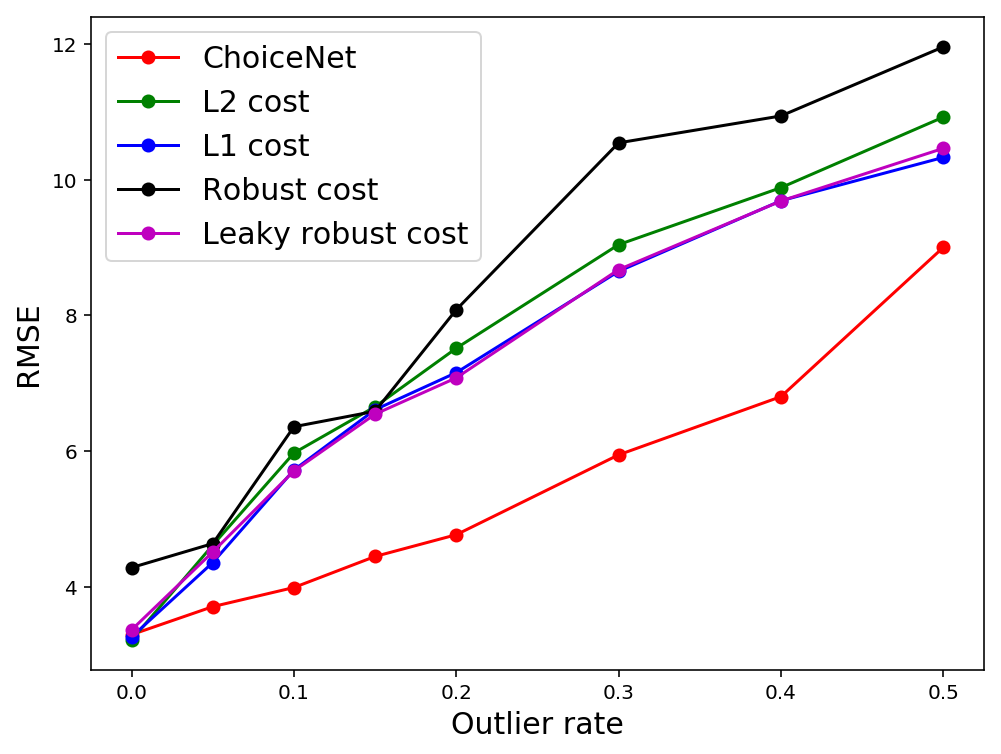

In [6]:
plt.figure(figsize=(8,6))
h_cn,=plt.plot(outlier_rates,rmses_cn.mean(axis=1),'o-',color='r')
h_l2,=plt.plot(outlier_rates,rmses_l2.mean(axis=1),'o-',color='g')
h_l1,=plt.plot(outlier_rates,rmses_l1.mean(axis=1),'o-',color='b')
h_robust,=plt.plot(outlier_rates,rmses_robust.mean(axis=1),'o-',color='k')
h_leaky,=plt.plot(outlier_rates,rmses_leaky_robust.mean(axis=1),'o-',color='m')
plt.legend([h_cn,h_l2,h_l1,h_robust,h_leaky],
          ['ChoiceNet','L2 cost','L1 cost','Robust cost','Leaky robust cost'],
          fontsize=15)
plt.xlabel('Outlier rate',fontsize=15)
plt.ylabel('RMSE',fontsize=15)
plt.savefig('fig/fig_%s_results.png'%(dataset_name))
plt.show()